# 1. Introduction

Fichier qui permet d'exporter les differentes donnees necessaires a la diffusion des graphs sur le web, via quelques fonctions qui les retraitent pour correspondre aux filtres attendus.

In [13]:
import gen_dataset_810 as mod_810fr
# importer datetime pour typer les donnees de dates des chaines et des videos
import datetime


# Définition des dates limites pour les filtres de https://s01.810.fr
datemin_2022 = datetime.datetime(2022, 1, 1, 0, 0, 0)
datemax_2022 = datetime.datetime(2022, 4, 1, 0, 0, 0)
datemin_2021 = datetime.datetime(2021, 1, 1, 0, 0, 0)

# Récupération des fichiers générés à partir des API YouTube
folder_candidats = './data_sources/stats_videos/2022_03_08/'
# Création d'un datafram qui agrège les fichiers
dt_candidats = mod_810fr.mb_ds()
# Génération d'un dataframe de vidéos et d'un dataframe de chaîne (exemple dans les blocs qui suivent)
videos_candidats_toutes, chaines_candidats_toutes  = dt_candidats.get_full_data_candidat(folder = folder_candidats)

# Création du dataframe de vidéos, spécial 2022
videos_candidats_2022 = videos_candidats_toutes[videos_candidats_toutes['dateVideo'] > datemin_2022]
videos_candidats_2022 = videos_candidats_2022[videos_candidats_2022['dateVideo'] < datemax_2022]

# Création du dataframe de vidéos, spécial 2021
videos_candidats_2021 = videos_candidats_toutes[videos_candidats_toutes['dateVideo'] > datemin_2021]
videos_candidats_2021 = videos_candidats_2021[videos_candidats_2021['dateVideo'] < datemin_2022]


dossier_output = './data_output/'
toptagsfolder_json = 'top-tags-json/'
activityfolder_json = 'activity-json/'
toptagsfolder_csv = 'top-tags-csv/'
activityfolder_csv = 'activity-csv/'

Imported 12 channel data


### 1.1 Affichage de la première ligne et du nombre de lignes totales


In [14]:
videos_candidats_toutes.head(1)

,dateRqt,candidat,parti,courant,chaine,titreVideo,vid_id,dateVideo,liste_tags,livebroadcast,vuesVideo,likesVideo,dislikesVideo,favVideo,comzVideo,dureeVideo
0,2022/03/08,Emmanuel Macron,LREM,centre,Emmanuel Macron,Quatre jours en Inde | Emmanuel Macron,UdVAF_3vVSw,2018-03-18 13:41:41,"[emmanuel, macron, inde, new delhi, bénarès, v...",none,1388604,55799,0,0,4256,0 days 00:05:29


In [15]:
videos_candidats_toutes.shape

(2964, 16)

In [16]:
chaines_candidats_toutes.head(1)

,dateRqt,candidat,parti,courant,chaine,dateCreationChaine,pays,categorieschaine,vuesChaine,abonnesChaine,nbVideosChaine
0,2022/03/08,Emmanuel Macron,LREM,centre,Emmanuel Macron,2017-10-03,FR,"[https://en.wikipedia.org/wiki/Society, https:...",17509175,243000,345


In [17]:
chaines_candidats_toutes.shape

(12, 11)

Maintenant que la liste officielle des candidats et candidates a été publiée, nous allons limiter notre traitement par courant, aux chaînes associées à la campagne de chaque candidat et candidate officel(le)

liste_candidats = ['Eric Zemmour', 'Avec vous', 'Jean-Luc Mélenchon', 'Valérie Pécresse', 'Yannick Jadot', 'Anne Hidalgo']

In [18]:
videos_candidats_toutes.candidat.unique()

array(['Emmanuel Macron', 'Nathalie Arthaud', 'Jean-Luc Mélenchon',
       'Jean Lassalle', 'Anne Hidalgo', 'Marine Le Pen',
       'Valérie Pécresse', 'Nicolas Dupont-Aignan', 'Yannick Jadot',
       'Avec vous', 'Eric Zemmour'], dtype=object)

In [19]:
liste_chaines_candidats_officiels = ["Anne Hidalgo",
                                    "Avec vous",
                                    "Eric Zemmour",
                                    "Jean Lassalle",
                                    "Jean-Luc Mélenchon",
                                    "Marine Le Pen",   
                                    "Nathalie Arthaud", 
                                    "Nicolas Dupont-Aignan",
                                    "Valérie Pécresse",  
                                    "Yannick Jadot"]

# Filtrage du dtf de toutes les vidéos à partir de la liste officielle
boolean_series_globale = videos_candidats_toutes.candidat.isin(liste_chaines_candidats_officiels)
videos_candidats_toutes = videos_candidats_toutes[boolean_series_globale]

# Filtrage des vidéos de l'année 2022
boolean_series_2022 = videos_candidats_2022.candidat.isin(liste_chaines_candidats_officiels)
videos_candidats_2022 = videos_candidats_2022[boolean_series_2022]

# Filtrage des vidéos de l'année 2021
boolean_series_2021 = videos_candidats_2021.candidat.isin(liste_chaines_candidats_officiels)
videos_candidats_2021 = videos_candidats_2021[boolean_series_2021]

# 2. Travail sur l'activité des courants et des candidats

Suivi d'activité : nb vidéos ; likes ; vues ; durée

## 2.2. Export des suivis d'activité mensuelle par courant

In [20]:
import gen_activitemensuelle_data_810 as amd810

# Generation des fichiers de synthese des courants
# On les dump dans les différents dossiers de "data_output/2022/"

###############################
# Annee 2022
###############################
# Dump nombre de vidéos
dtf_global_nbvids = amd810.make_synthese_nbvideo_par_courant(videos_candidats_2022, indicateur="nb videos", annee= 2022)
amd810.dump_synthese_courants(dtf_synth_courant=dtf_global_nbvids, nomfichier=dossier_output + activityfolder_json +'synthese_nbvideos_courant_2022.json')

# Dump nombre de likes
dtf_global_likes = amd810.make_synthese_nbvideo_par_courant(videos_candidats_2022, indicateur="likes", annee= 2022)
amd810.dump_synthese_courants(dtf_synth_courant=dtf_global_likes, nomfichier=dossier_output + activityfolder_json + 'synthese_likes_courant_2022.json')

# Dump nombre de vues
dtf_global_vues = amd810.make_synthese_nbvideo_par_courant(videos_candidats_2022, indicateur="vues", annee= 2022)
amd810.dump_synthese_courants(dtf_synth_courant=dtf_global_vues, nomfichier=dossier_output + activityfolder_json + 'synthese_vues_courant_2022.json')

# Dumper les CSV pour datawrapper.de
dtf_global_nbvids.to_csv(dossier_output + activityfolder_csv + 'synthese_nbvideos_courant_2022.csv')
dtf_global_likes.to_csv(dossier_output + activityfolder_csv + 'synthese_likes_courant_2022.csv')
dtf_global_vues.to_csv(dossier_output + activityfolder_csv + 'synthese_vues_courant_2022.csv')


###############################
# Annee 2021
###############################
# Dump nombre de vidéos
dtf_global_nbvids = amd810.make_synthese_nbvideo_par_courant(videos_candidats_2021, indicateur="nb videos", annee= 2021)
amd810.dump_synthese_courants(dtf_synth_courant=dtf_global_nbvids, nomfichier=dossier_output + activityfolder_json +'synthese_nbvideos_courant_2021.json')

# Dump nombre de likes
dtf_global_likes = amd810.make_synthese_nbvideo_par_courant(videos_candidats_2021, indicateur="likes", annee= 2021)
amd810.dump_synthese_courants(dtf_synth_courant=dtf_global_likes, nomfichier=dossier_output + activityfolder_json + 'synthese_likes_courant_2021.json')

# Dump nombre de vues
dtf_global_vues = amd810.make_synthese_nbvideo_par_courant(videos_candidats_2021, indicateur="vues", annee= 2021)
amd810.dump_synthese_courants(dtf_synth_courant=dtf_global_vues, nomfichier=dossier_output + activityfolder_json + 'synthese_vues_courant_2021.json')

# Dumper les CSV pour datawrapper.de
dtf_global_nbvids.to_csv(dossier_output + activityfolder_csv + 'synthese_nbvideos_courant_2021.csv')
dtf_global_likes.to_csv(dossier_output + activityfolder_csv + 'synthese_likes_courant_2021.csv')
dtf_global_vues.to_csv(dossier_output + activityfolder_csv + 'synthese_vues_courant_2021.csv')


## 2.3. Export des suivis d'activite mensuelle des candidats et candidates

In [21]:
liste_candidats = ['Eric Zemmour', 'Avec vous', 'Jean-Luc Mélenchon', 'Valérie Pécresse', 'Yannick Jadot', 'Anne Hidalgo', "Jean Lassalle"]

In [22]:
###############################
# Annee 2022
###############################
# Dump nombre de vidéos
dtf_candidat_perf = amd810.make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2022, indicateur = "nb videos", liste_candidats =liste_candidats, annee=2022)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
amd810.dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json + 'synthese_nbvideos_candidats_2022.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_nbvideos_candidats_2022.csv')

# Dump likes
dtf_candidat_perf = amd810.make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2022, indicateur = "likes", liste_candidats =liste_candidats, annee=2022)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
amd810.dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json + 'synthese_likes_candidats_2022.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_likes_candidats_2022.csv')

# Dump vues
dtf_candidat_perf = amd810.make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2022, indicateur = "vues", liste_candidats =liste_candidats, annee=2022)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
amd810.dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json +'synthese_vues_candidats_2022.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_vues_candidats_2022.csv')


###############################
# Annee 2021
###############################
# Dump nombre de vidéos
dtf_candidat_perf = amd810.make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2021, indicateur = "nb videos", liste_candidats =liste_candidats, annee=2021)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
amd810.dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json + 'synthese_nbvideos_candidats_2021.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_nbvideos_candidats_2021.csv')

# Dump likes
dtf_candidat_perf = amd810.make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2021, indicateur = "likes", liste_candidats =liste_candidats, annee=2021)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
amd810.dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json + 'synthese_likes_candidats_2021.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_likes_candidats_2021.csv')

# Dump vues
dtf_candidat_perf = amd810.make_synthese_nbvideo_par_candidat(dtsource=videos_candidats_2021, indicateur = "vues", liste_candidats =liste_candidats, annee=2021)
dtf_candidat_perf = dtf_candidat_perf.rename(columns={'Avec vous': 'Emmanuel Macron'})
amd810.dump_synthese_candidats_v0(dtf_synth_candidat=dtf_candidat_perf, nomfichier=dossier_output + activityfolder_json +'synthese_vues_candidats_2021.json')
dtf_candidat_perf.to_csv(dossier_output + activityfolder_csv + 'synthese_vues_candidats_2021.csv')


# 3. Travail sur les Tags

On va dumper un CSV par mois, qu'on utilisera sur le site https://810.fr pour faire des articles

On va dumper un json sur toute l'année 2022 pour le publier sur https://s01.810.fr

In [23]:
import gen_tags_visu_810 as tv810

debutjanv22 =  datetime.datetime(2022,1,1,0,0,0)
debutjanv23 =  datetime.datetime(2023,1,1,0,0,0)
videos_candidats_2022_full = videos_candidats_toutes[videos_candidats_toutes['dateVideo'] > debutjanv22]
videos_candidats_2022_full = videos_candidats_2022_full[videos_candidats_2022_full['dateVideo'] < debutjanv23]

## 3.2. Export des données par courants

### 3.2.1. Extrême droite

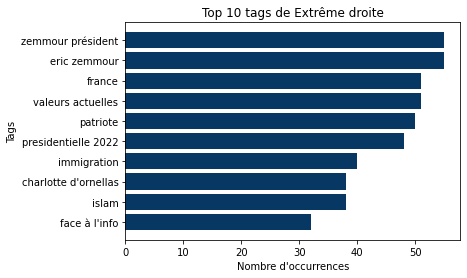

In [24]:
# Année 2022
subdtf_videos = videos_candidats_2022_full
videos_xd_22, videos_xg_22, videos_d_22, videos_g_22, videos_c_22, videos_v_22, videos_reste_22 = amd810.un_dtf_par_courant(subdtf=subdtf_videos)
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_xd_22, colonne = 'courant', valeur = 'Extrême droite', top = 10, titre = '', color = "#073763", liste_exceptions = ['Debout La France', 'Nicolas Dupont-Aignan', 'zemmour', 'zemmour 2022', 'Z00Z'])
# Dump des fichiers
tv810.dump_tags_json(toptags=top_tags, nomfichier= dossier_output + toptagsfolder_json + "top_tags_extreme_droite_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_extreme_droite_2022.csv')

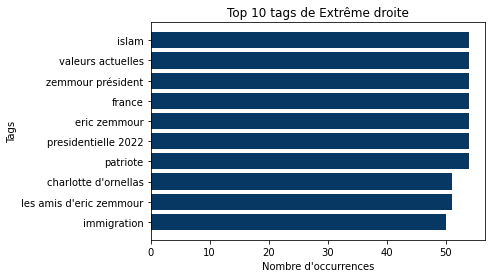

In [25]:
# Année 2021
subdtf_videos = videos_candidats_2021
videos_xd_21, videos_xg_21, videos_d_21, videos_g_21, videos_c_21, videos_v_21, videos_reste_21 = amd810.un_dtf_par_courant(subdtf=subdtf_videos)
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_xd_21, colonne = 'courant', valeur = 'Extrême droite', top = 10, titre = '', color = "#073763", liste_exceptions = ['Debout La France', 'Nicolas Dupont-Aignan', 'zemmour', 'zemmour 2022', 'Z00Z'])
# Dump des fichiers
tv810.dump_tags_json(toptags=top_tags, nomfichier= dossier_output + toptagsfolder_json + "top_tags_extreme_droite_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_extreme_droite_2021.csv')

### 3.2.2. Extrême gauche

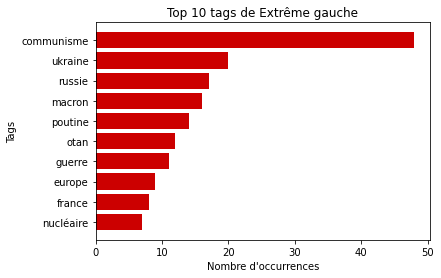

In [26]:
# Année 2022
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_xg_22, colonne = 'courant', valeur = 'Extrême gauche', top = 10, titre = '', color = "#cc0000", liste_exceptions = ['Nathalie', 'Lutte', 'ouvrière', 'Arthaud', 'LO', 'mélenchon'])
tv810.dump_tags_json(toptags=top_tags, nomfichier= dossier_output + toptagsfolder_json + "top_tags_extreme_gauche_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_extreme_gauche_2022.csv')

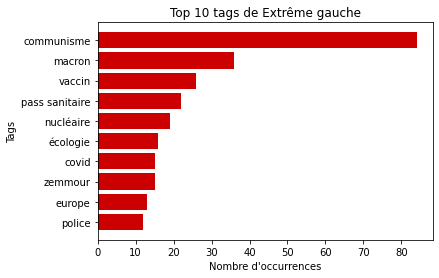

In [27]:
# Année 2021
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_xg_21, colonne = 'courant', valeur = 'Extrême gauche', top = 10, titre = '', color = "#cc0000", liste_exceptions = ['Nathalie', 'Lutte', 'ouvrière', 'Arthaud', 'LO', 'mélenchon'])
tv810.dump_tags_json(toptags=top_tags, nomfichier= dossier_output + toptagsfolder_json + "top_tags_extreme_gauche_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_extreme_gauche_2021.csv')

### 3.2.3. Droite

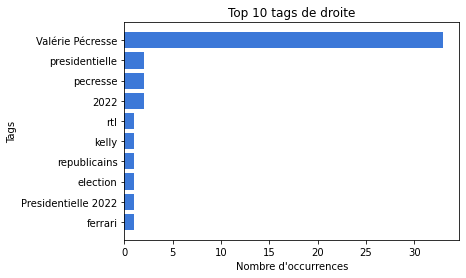

In [28]:
# Année 2022
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_d_22, colonne = 'courant', valeur = 'droite', top = 10, titre = '', color = "#3c78d8")
tv810.dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_droite_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_droite_2022.csv')

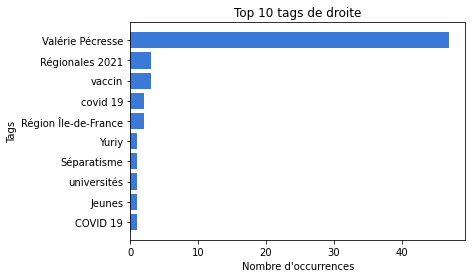

In [29]:
# Année 2021
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_d_21, colonne = 'courant', valeur = 'droite', top = 10, titre = '', color = "#3c78d8")
tv810.dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_droite_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_droite_2021.csv')

### 3.2.4. Gauche

In [30]:
# Année 2022
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_g_22, colonne = 'courant', valeur = 'gauche', top = 10, titre = '', color = "#e6a3bf")
tv810.dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_gauche_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_gauche_2022.csv')

Aucun tags trouvés sur les vidéos sélectionnées


In [31]:
# Année 2021
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_g_21, colonne = 'courant', valeur = 'gauche', top = 10, titre = '', color = "#e6a3bf")
tv810.dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_gauche_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_gauche_2021.csv')

Aucun tags trouvés sur les vidéos sélectionnées


### 3.2.5. Verts

impossible de dropper Les Verts


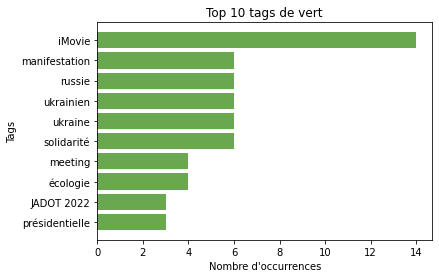

In [32]:
# Année 2022
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_v_22, colonne = 'courant', valeur = 'vert', top = 10, titre = '', color = "#6aa84f", liste_exceptions=['jadot 2022', 'yannick jadot', 'Les Verts'])
tv810.dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_verts_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_verts_2022.csv')

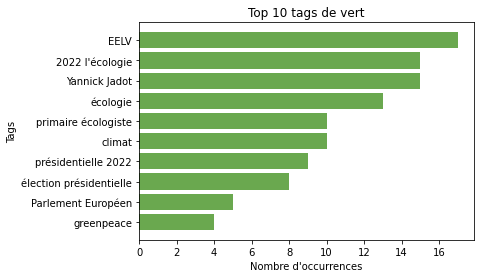

In [33]:
# Année 2021
# On va filtrer pas mal de tags, car il y en a plusieurs qui ne sont pas très parlant
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_v_21, colonne = 'courant', valeur = 'vert', top = 10, titre = '', color = "#6aa84f", liste_exceptions=['jadot 2022', 'yannick jadot', 'Europe Écologie Les Verts', 'Les Verts', '2022lecologie.fr', 'candidature écologie', 'Yannick Jadot 2022', 'Q&A', 'écologistes', 'Jadot2022', 'Jadot 2022'])
tv810.dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_verts_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_verts_2021.csv')

#### Bonus : Dumper tous les tags des verts

On a remarqué que certains tags des verts étaient très surprenants. On a donc fait une fonction qui permet de récupérer ces tags

In [34]:
hash_v = tv810.create_hashtagliste_dataframe(videos_v_22)
hash_v.head(2)

,NomO,dateP,hashtag,nbLikes
0,YANNICK JADOT FACE À BFM TV,2022-02-16 12:04:04,#jadot2022,244
1,YANNICK JADOT FACE À BFM TV,2022-02-16 12:04:04,#yannickjadot,244


### 3.2.6. Majorité

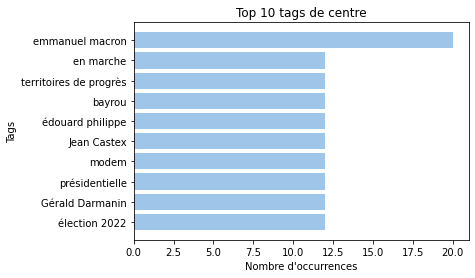

In [35]:
# Année 2022
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_c_22, colonne = 'courant', valeur = 'centre', top = 10, titre = '', color = "#9fc5e8", liste_exceptions=['macron'])
tv810.dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_majorite_2022.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_majorite_2022.csv')

In [36]:
# Année 2021
# On sait que ce sera vide, vu que la chaîne a commencé à exister en 2022, mais nous agissons comme des machines
top_tags = tv810.liste_top_tags_de_chaines (dtfv = videos_c_21, colonne = 'courant', valeur = 'centre', top = 10, titre = '', color = "#9fc5e8")
tv810.dump_tags_json(toptags=top_tags, nomfichier=dossier_output + toptagsfolder_json + "top_tags_majorite_2021.json")
top_tags.to_csv(dossier_output + toptagsfolder_csv + 'top_tags_majorite_2021.csv')

Aucun tags trouvés sur les vidéos sélectionnées


# Préparation des transcripts pour notre traitement suivant

Ici, on liste les vidéos pour lesquelles on va vouloir récupérer le transcript.

Dans notre cas, on souhaite ne travailler pour l'instant que sur le mois de février.

In [37]:
date_segment = {"datemin" : datetime.datetime(2022,2,1,0,0,0), "datemax" : datetime.datetime(2022,3,1,0,0,0)}
video_du_mois = videos_candidats_2022[videos_candidats_2022['dateVideo'] > date_segment["datemin"]]
video_du_mois = video_du_mois[video_du_mois["dateVideo"] < date_segment["datemax"]]
video_du_mois.shape[0]

231

In [38]:
video_du_mois.to_csv('./temp_files/liste_de_video_pour_transcript_analyse.csv')

# Extraction de quelques stats globales pour le bandeau défilant

In [39]:
video_du_mois.vuesVideo.sum()

17853409

In [40]:
video_du_mois.shape[0]

231